# Adversarial Search: Solving Tic-Tac-Toe with Minimax Search and Alpha-Beta Pruning

## Introduction 

Multiplayer games can be implemented as:
1. Nondeterministic actions: The opponent is seen as part of an environment with nondeterministic actions. Non-determinism is the result of the unknown opponent's moves. 
2. __Optimal Decisions:__ Minimax search (search complete game tree) and alpha-beta pruning.
3. Heuristic Alpha-Beta Tree Search: Cut off tree search and use heuristic to estimate state value. 
4. Monte Carlo Tree search: Simulate playouts to estimate state value. 

Here we will implement search for Tic-Tac-Toe (see [rules](https://en.wikipedia.org/wiki/Tic-tac-toe)). The game is a __zero-sum game__: Win by x results in +1, win by o in -1 and a tie has a value of 0. Max plays x and tries to maximize the outcome while Min plays o and tries to minimize the outcome.   

We will implement
* __minimax search,__
* __minimax search with alpha-beta pruning,__ and
* __move ordering__. 

The search time (number if nodes explored) could be further improved by 
* __heuristic alpha-beta tree search__ (cut off search and use heuristic evaluation function to approximate utility), 
* __forward pruning__ (prune moves that appear poor), and
* __table lookups__ (for openings and end game).

The algorithms search the game tree and we could return a conditional plan (or partial plan if cut offs are used), but the implementation here only identifies and returns the optimal next move.

The code for the basic functions used for search are implemented in [tictactoe.py](tictactoe.py).

In [ ]:
# download if missing
import urllib.request
import os

def download(file, base_url):
    if not os.path.exists(file):
        urllib.request.urlretrieve(base_url + file, file)

download("tictactoe.py", 
         "https://raw.githubusercontent.com/mhahsler/Introduction_to_Artificial_Intelligence/refs/heads/master/Games/")

In [16]:
from tictactoe import empty_board, actions, result, terminal, utility, other, show_board
from tictactoe import random_player, play 

# Recursive DFS algorithm for Minimax Search

See AIMA page 150. 

Note that the minimax search algorithm is very similar to AND-OR search where max does OR and min is represented by AND nodes.

In [17]:
import math

# global variables
DEBUG = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def minimax_search(board, player = 'x'):
    """start the search."""
    global DEBUG, COUNT
    COUNT = 0
    
    value, move = max_value(board, player)
    
    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}") 
 
    return { "move": move, "value": value}

def max_value(state, player):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1
    
    # return utility of state if it is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print("max in: " + str(state) + str([v]) ) 
    if v is not None: return v, None
        
    v, move = -math.inf, None

    # check all possible actions in the state, return move with the largest value
    for a in actions(state):
        v2, a2 = min_value(result(state, player, a), player)
        if v2 > v:
            v, move = v2, a
    
    if DEBUG >= 2: print("max out: " + str(state) + str([v, move]) ) 
    return v, move

def min_value(state, player):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # return utility of state if it is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print("min in: " + str(state) + str([v]) ) 
    if v is not None: return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, return move with the smallest value
    for a in actions(state):
        v2, a2 = max_value(result(state, other(player), a), player)
        if v2 < v:
            v, move = v2, a
    
    if DEBUG >= 2: print("min out: " + str(state) + str([v, move]) ) 
    return v, move

## Some Tests

### x is about to win (choose 8)

Board:


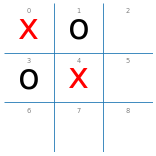


Number of nodes searched: 190


{'move': 2, 'value': 1}

CPU times: user 4.29 ms, sys: 2 μs, total: 4.29 ms
Wall time: 4.1 ms


In [18]:
board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[3] = 'o'
board[4] = 'x'

print("Board:")
show_board(board)

print()
%time display(minimax_search(board))

**Note:** DFS does not pick the the shortest path to a win! Discounting the utility can help.

### x can draw if it chooses 7

Board:


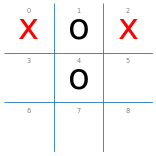


Number of nodes searched: 206


{'move': 7, 'value': 0}

CPU times: user 5.89 ms, sys: 14 μs, total: 5.91 ms
Wall time: 5.58 ms


In [19]:
board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[2] = 'x'
board[4] = 'o'

print("Board:")
show_board(board)

print()
%time display(minimax_search(board))

### A bad situation


Board:


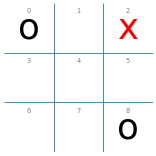


Number of nodes searched: 941


{'move': 1, 'value': -1}

CPU times: user 19.7 ms, sys: 0 ns, total: 19.7 ms
Wall time: 19.2 ms


In [20]:
board = empty_board() 
board[0] = 'o'
board[2] = 'x'
board[8] = 'o'

print("Board:")
show_board(board)

print()
%time display(minimax_search(board))

### Empty board

Board:


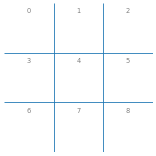


Number of nodes searched: 549946


{'move': 0, 'value': 0}

CPU times: user 8.6 s, sys: 3.98 ms, total: 8.6 s
Wall time: 8.61 s


In [21]:
board = empty_board() 

print("Board:")
show_board(board)


print()
%time display(minimax_search(board))

__Note:__ Starting with an empty board searched the complete game tree and takes a while. The number of nodes above is the actual size of the complete game tree. A table with know 'openings' (e.g., place x in a corner, o chooses the center, etc.) would be helpful to speed things up.

# Recursive DFS algorithm for Minimax Search with Alpha-Beta Pruning

See AIMA page 154. 

Adds alpha-beta pruning to minimax search. Alpha and beta are used to maintain bounds on the minimax value of a node in the form `[alpha, beta]`. alpha means that the value is at least that high and beta means that the actual value is at most that high. Subtrees below a node that are worse than the currently known bound do not need to be further explored and can be pruned. Max uses alpha and Min uses beta for pruning.

The implementation is for player 'x' returns a the optimal next move.

In [22]:
# global variables
DEBUG = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def alpha_beta_search(board, player = 'x'):
    """start the search."""
    global DEBUG, COUNT
    COUNT = 0
    
    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    
    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}") 
    
    return { "move": move, "value": value }

def max_value_ab(state, player, alpha, beta):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1
       
    # return utility of state is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print(f"max: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None: 
        if DEBUG >= 2: print(f"     found terminal state. backtracking.")
        return v, None
        
    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in actions(state):
        v2, a2 = min_value_ab(result(state, player, a), player, alpha, beta)
        if DEBUG >= 2: print(f"max: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")
        
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            if DEBUG >= 2: print(f"     v>=beta ({v}>={beta}): pruning remaining subtree (actions). backtracking.")
            return v, move
    
    return v, move

def min_value_ab(state, player, alpha, beta):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # return utility of state is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print(f"min: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None: 
        if DEBUG >= 2: print(f"     found terminal state. backtacking.")
        return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in actions(state):
        v2, a2 = max_value_ab(result(state, other(player), a), player, alpha, beta)
        if DEBUG >= 2: print(f"min: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")
        
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: 
            if DEBUG >= 2: print(f"     v<=alpha ({v}<={alpha}): pruning remaining subtree (actions). backtracking.")
            return v, move
    
    return v, move

## Some Tests

### x is about to win (play 8)

Board:


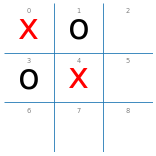


max: ['x', 'o', ' ', 'o', 'x', ' ', ' ', ' ', ' '] [alpha,beta]=[-inf,inf] v=None
min: ['x', 'o', 'x', 'o', 'x', ' ', ' ', ' ', ' '] [alpha,beta]=[-inf,inf] v=None
max: ['x', 'o', 'x', 'o', 'x', 'o', ' ', ' ', ' '] [alpha,beta]=[-inf,inf] v=None
min: ['x', 'o', 'x', 'o', 'x', 'o', 'x', ' ', ' '] [alpha,beta]=[-inf,inf] v=1
     found terminal state. backtacking.
max: ['x', 'o', 'x', 'o', 'x', 'o', ' ', ' ', ' '] (backtracked) [alpha,beta]=[-inf,inf] v=1
min: ['x', 'o', 'x', 'o', 'x', 'o', ' ', 'x', ' '] [alpha,beta]=[1,inf] v=None
max: ['x', 'o', 'x', 'o', 'x', 'o', 'o', 'x', ' '] [alpha,beta]=[1,inf] v=None
min: ['x', 'o', 'x', 'o', 'x', 'o', 'o', 'x', 'x'] [alpha,beta]=[1,inf] v=1
     found terminal state. backtacking.
max: ['x', 'o', 'x', 'o', 'x', 'o', 'o', 'x', ' '] (backtracked) [alpha,beta]=[1,inf] v=1
min: ['x', 'o', 'x', 'o', 'x', 'o', ' ', 'x', ' '] (backtracked) [alpha,beta]=[1,inf] v=1
     v<=alpha (1<=1): pruning remaining subtree (actions). backtracking.
max: ['x', 'o'

{'move': 2, 'value': 1}

CPU times: user 6.2 ms, sys: 13 μs, total: 6.21 ms
Wall time: 5.89 ms


In [23]:
DEBUG = 2 # show more debugging info

board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[3] = 'o'
board[4] = 'x'

print("Board:")
show_board(board)

print()
%time display(alpha_beta_search(board))

The code does not pick the the shortest path to a win! Discounting could help.

### x can draw if it chooses 7

Board:


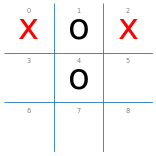


Number of nodes searched: 101


{'move': 7, 'value': 0}

CPU times: user 3.62 ms, sys: 0 ns, total: 3.62 ms
Wall time: 3.46 ms


In [24]:
DEBUG = 1

board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[2] = 'x'
board[4] = 'o'

print("Board:")
show_board(board)

print()
%time display(alpha_beta_search(board))

### o is about to win no matter what x does


Board:


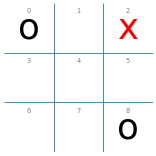


Number of nodes searched: 238


{'move': 1, 'value': -1}

CPU times: user 4.9 ms, sys: 6 μs, total: 4.9 ms
Wall time: 4.76 ms


In [25]:
board = empty_board() 
board[0] = 'o'
board[2] = 'x'
board[8] = 'o'

print("Board:")
show_board(board)

print()
%time display(alpha_beta_search(board))

### Empty board: Only a draw an be guaranteed

Board:


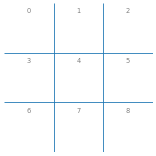


Number of nodes searched: 18297


{'move': 0, 'value': 0}

CPU times: user 369 ms, sys: 3.98 ms, total: 373 ms
Wall time: 372 ms


In [26]:
board = empty_board() 

print("Board:")
show_board(board)


print()
%time display(alpha_beta_search(board))

**Note:** Alpha-Beta search expands fewer nodes and is **much faster** than minimax search. 

## Move ordering

Smart move reordering can make alpha-beta pruning more effective. I think the center `[4]` and corners `[0, 2, 6, 8]` are good. I implement move reordering in the `actions()`.

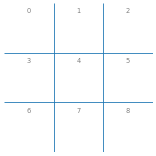

[4, 8, 6, 2, 0, 7, 5, 3, 1]

In [27]:
import numpy as np

def actions(board):
    """return possible actions as a vector ot indices"""
    actions = np.where(np.array(board) == ' ')[0].tolist()

    priority = [1,0,1,
                0,2,0,
                1,0,1]
    priority = [priority[i] for i in actions]
    
    actions =[a for _,a in sorted(zip(priority,actions), reverse=True)]
    
    return actions

board = empty_board()   
show_board(board)
actions(board)

### Empty board: Only a draw an be guaranteed

Board:


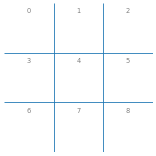


Number of nodes searched: 7275


{'move': 4, 'value': 0}

CPU times: user 200 ms, sys: 0 ns, total: 200 ms
Wall time: 199 ms


In [28]:
board = empty_board() 

print("Board:")
show_board(board)


print()
%time display(alpha_beta_search(board))

__Note:__ Compare to the number of nodes searched without move reordering (right above).

## Experiments


### Minimax with Alpha-Beta Pruning vs. Random

In [29]:
DEBUG = 0

def alpha_beta_player(board, player = 'x'):
    return alpha_beta_search(board, player)["move"]

print("alpha-beta vs. random:")
%time display(play(alpha_beta_player, random_player))

print()
print("random vs. alpha-beta")
%time display(play(random_player, alpha_beta_player))

alpha-beta vs. random:


{'x': 99, 'o': 0, 'd': 1}

CPU times: user 17.6 s, sys: 5 μs, total: 17.6 s
Wall time: 17.6 s

random vs. alpha-beta


{'x': 0, 'o': 88, 'd': 12}

CPU times: user 4.34 s, sys: 0 ns, total: 4.34 s
Wall time: 4.34 s


**Note on runtime:** Compared to AND-OR Search, Minimax search is slower, because AND-OR Search terminates once it finds the first subtree that has only goal nodes, buy Minimax search traverses the whole tree (minus what is pruned if alpha-beta pruning is used). 

Also, I was lazy and recreate the search tree every time the agent is asked for a move. The agent could create the tree with the Minimax values once and then use it to decide on actions. A problem could be that the tree may be too large to store. 